In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        v2.RandomRotation(30),
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        self.filepaths = glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True)
        self.classes = ['real', 'fake']
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        
        # Extract the class name from the filepath
        class_name = self.classes[1] if "Fake" in os.path.dirname(os.path.relpath(filepath, data_dir)) else self.classes[0]
        
        # Map the class name to 'real' or 'fake'
        class_label = self.classes.index(class_name)

        # Load and transform the image
        image = Image.open(filepath)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, class_label

In [8]:
data_dir = "/kaggle/input/projectdata"
data = {}
data["train"] = CustomDataset(os.path.join(data_dir, "train"), transform = data_transforms["train"])
data["val"] = CustomDataset(os.path.join(data_dir, "val"), transform = data_transforms["val"])

In [9]:
print(len(data["train"]))
print(len(data["val"]))

49061
6075


In [10]:
dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [11]:
class_names = data['train'].classes
print(class_names)

['real', 'fake']


In [12]:
# shape of one image
data['train'][0][0].shape


torch.Size([3, 224, 224])

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
inputs, classes = next(iter(dataloaders['train']))

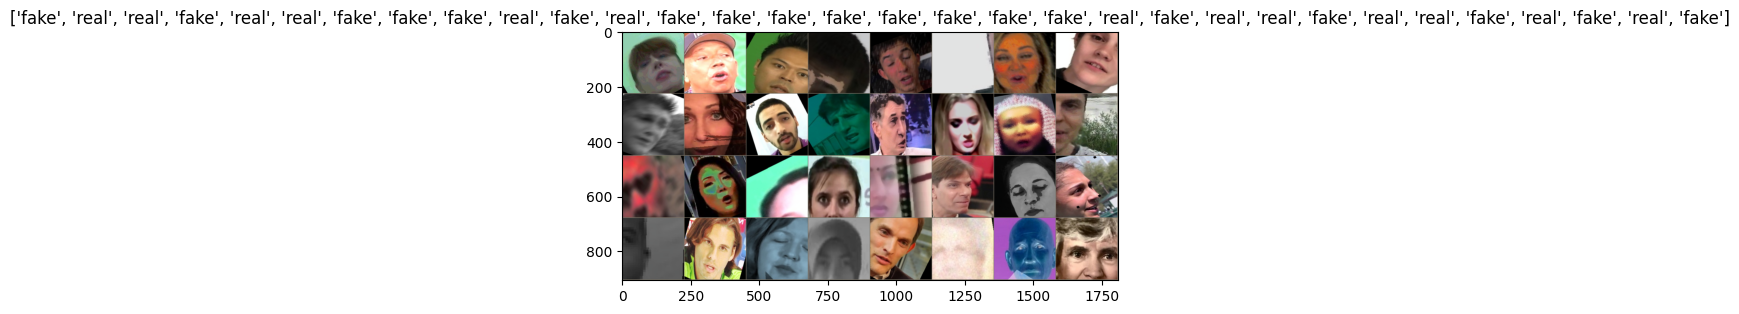

In [15]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Temp dir to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval() # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                
                # iter over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the param gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        #load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [25]:
def train_model_early_stop(model, criterion, optimizer, scheduler, loss_threshold = 1e-3):
    since = time.time()

    # Temp dir to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        old_tr_loss = None
        early_stop = False
        epoch = 0
        while not early_stop:
            epoch += 1
            print(f'Epoch {epoch}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval() # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                
                # iter over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the param gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                if phase == 'train':
                    if epoch>0 and old_tr_loss - epoch_loss>=loss_threshold:
                        old_tr_loss = epoch_loss
                    else:
                        print("Early stoppage")
                        early_stop = True
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
        
            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        #load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            ouputs = model(inputs)
            _, preds = torch.max(ouputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [27]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft = train_model_early_stop(model_ft, criterion, optimizer_ft, exp_lr_scheduler, loss_threshold = 1e-3)

Epoch 1
----------
